In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

import seaborn as sns
from sklearn.metrics import confusion_matrix ,classification_report

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.layers import Dense ,Conv2D , Dropout,Flatten ,MaxPooling2D ,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings ('ignore')

2024-05-26 22:51:07.142787: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-26 22:51:07.142912: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-26 22:51:07.261067: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
class Config:
    batch_size = 96
    epochs = 25
    DIR = '/kaggle/input/chest-xray-pneumonia/chest_xray'
    num_classes = 2
    image_size = 180

## Read the dataset

In [3]:
def plot_pie_chart(dir, data):
    plt.figure(figsize=(6, 6))

    x = [(len(os.listdir(dir + "/NORMAL"))), (len(os.listdir(dir + "/PNEUMONIA")))]
    plt.pie(x, labels=data.class_names, autopct='%1.1f%%')
    # get last part of directory
    dir = dir.split('/')[-1]
    plt.title(f'Distribution of the classes in the {dir} set')
    plt.show()

In [4]:
def read_data(CONFIG):
    train_dir = CONFIG.DIR + '/train'
    test_dir = CONFIG.DIR + '/test'
    valid_dir = CONFIG.DIR + '/val'
    train = keras.utils.image_dataset_from_directory(
        train_dir,
        labels='inferred',
        label_mode='categorical',
        batch_size=CONFIG.batch_size,
        image_size=(CONFIG.image_size, CONFIG.image_size),
    )
    valid = keras.utils.image_dataset_from_directory(
        valid_dir,
        labels='inferred',
        label_mode='categorical',
        batch_size=CONFIG.batch_size,
        image_size=(CONFIG.image_size, CONFIG.image_size),
    )
    test = keras.utils.image_dataset_from_directory(
        test_dir,
        labels='inferred',
        label_mode='categorical',
        batch_size=CONFIG.batch_size,
        image_size=(CONFIG.image_size, CONFIG.image_size),
    )
    # plot pie chart for the distribution of the classes
    plot_pie_chart(train_dir, train)
    plot_pie_chart(valid_dir, valid)
    plot_pie_chart(test_dir, test)

    return train, valid, test

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


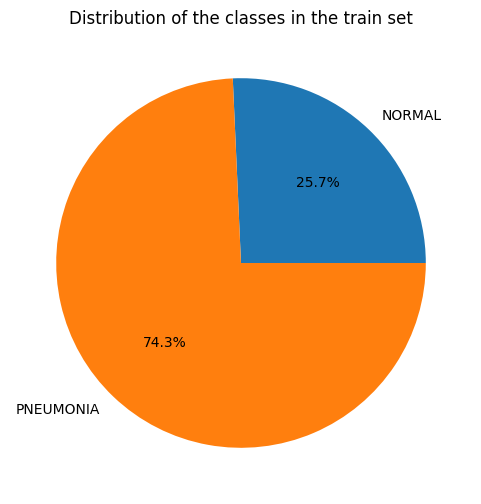

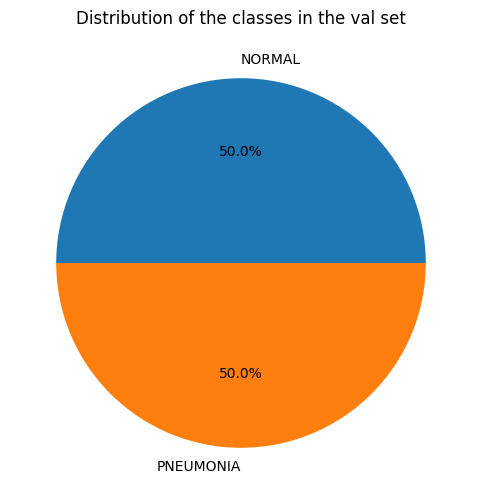

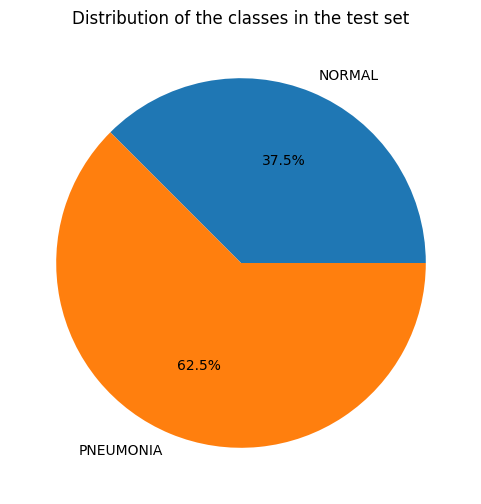

In [5]:
CONFIG = Config()
# Read the dataset
train, valid, test = read_data(CONFIG)
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = valid.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test.cache().prefetch(buffer_size=AUTOTUNE)

['NORMAL', 'PNEUMONIA']


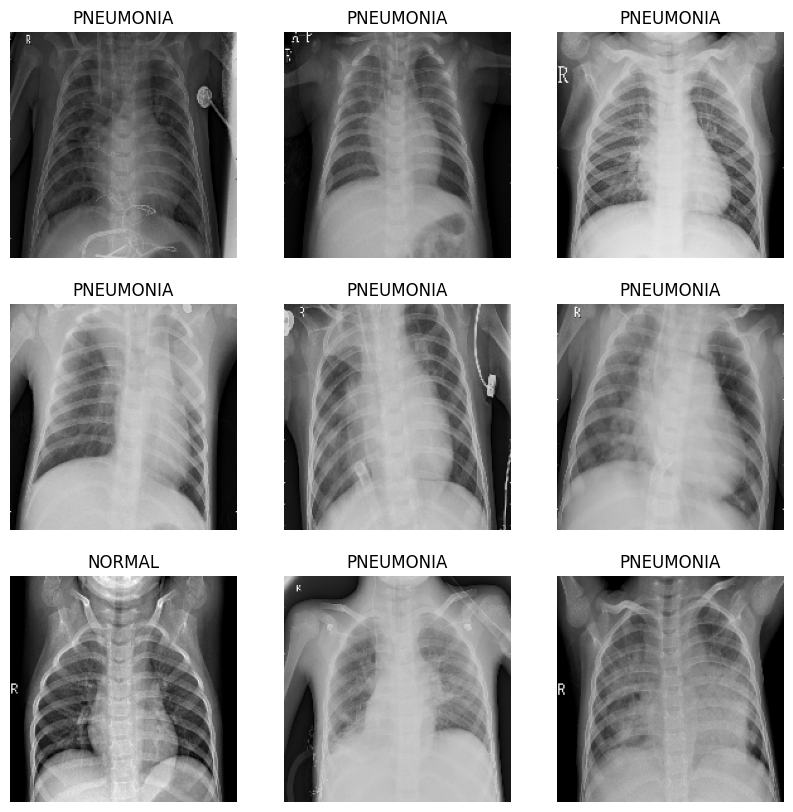

In [6]:
import matplotlib.pyplot as plt
class_names = train.class_names
print(class_names)
plt.figure(figsize=(10, 10))
for images, labels in train.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    index = np.argmax(labels[i])  # get image index
    plt.title(class_names[index])
    plt.axis("off")

In [7]:
from tensorflow.keras import layers, models
def build_model(CONFIG):
    model = tf.keras.Sequential([

        layers.Conv2D(256, (3, 3), padding='same', activation='relu', input_shape=(CONFIG.image_size,CONFIG.image_size, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(axis=1),

        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(axis=1),
        
        layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(axis=1),

        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),

        # Output layer
        layers.Dense(CONFIG.num_classes, activation='sigmoid')
    ])
    learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.001,
        decay_steps=10000,
        decay_rate=0.96
    )

    # Create an optimizer with the learning rate schedule
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_schedule)
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy'])
    return model

def train(model, train_ds, val_ds, CONFIG):
    callbacks = [
        keras.callbacks.ModelCheckpoint('model.keras', save_best_only=True),
    ]
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=CONFIG.epochs,
         callbacks=callbacks
    ) 
    return model, history

In [8]:
strategy = tf.distribute.MirroredStrategy()
# Build the model
with strategy.scope():
    model = build_model(CONFIG)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 180, 180, 256)  │         7,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 90, 90, 256)    │           360 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 64)     │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 45, 45, 64)     │           180 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 16)     │         9,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 22, 22, 16)     │            88 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 7744)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7744)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       495,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 660,358 (2.52 MB)

 Trainable params: 660,044 (2.52 MB)

 Non-trainable params: 314 (1.23 KB)

In [9]:
model, history = train(model, train_ds, val_ds, CONFIG)

Epoch 1/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 44s 487ms/step - accuracy: 0.6774 - loss: 0.8896 - val_accuracy: 0.5000 - val_loss: 13.8592
Epoch 2/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 16s 285ms/step - accuracy: 0.7474 - loss: 0.4862 - val_accuracy: 0.6250 - val_loss: 2.3189
Epoch 3/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 16s 284ms/step - accuracy: 0.7453 - loss: 0.3803 - val_accuracy: 0.5000 - val_loss: 1.2171
Epoch 4/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 16s 285ms/step - accuracy: 0.7598 - loss: 0.3193 - val_accuracy: 0.5000 - val_loss: 1.1533
Epoch 5/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 16s 285ms/step - accuracy: 0.9057 - loss: 0.2516 - val_accuracy: 0.7500 - val_loss: 0.9382
Epoch 6/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 16s 284ms/step - accuracy: 0.9364 - loss: 0.1696 - val_accuracy: 0.5000 - val_loss: 1.7134
Epoch 7/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 16s 284ms/step - accuracy: 0.9472 - loss: 0.1344 - val_accuracy: 0.5000 - val_loss: 2.0289
Epoch 8/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 16s 284ms/step - accuracy: 0.9551 - loss: 0.1295 - val_acc

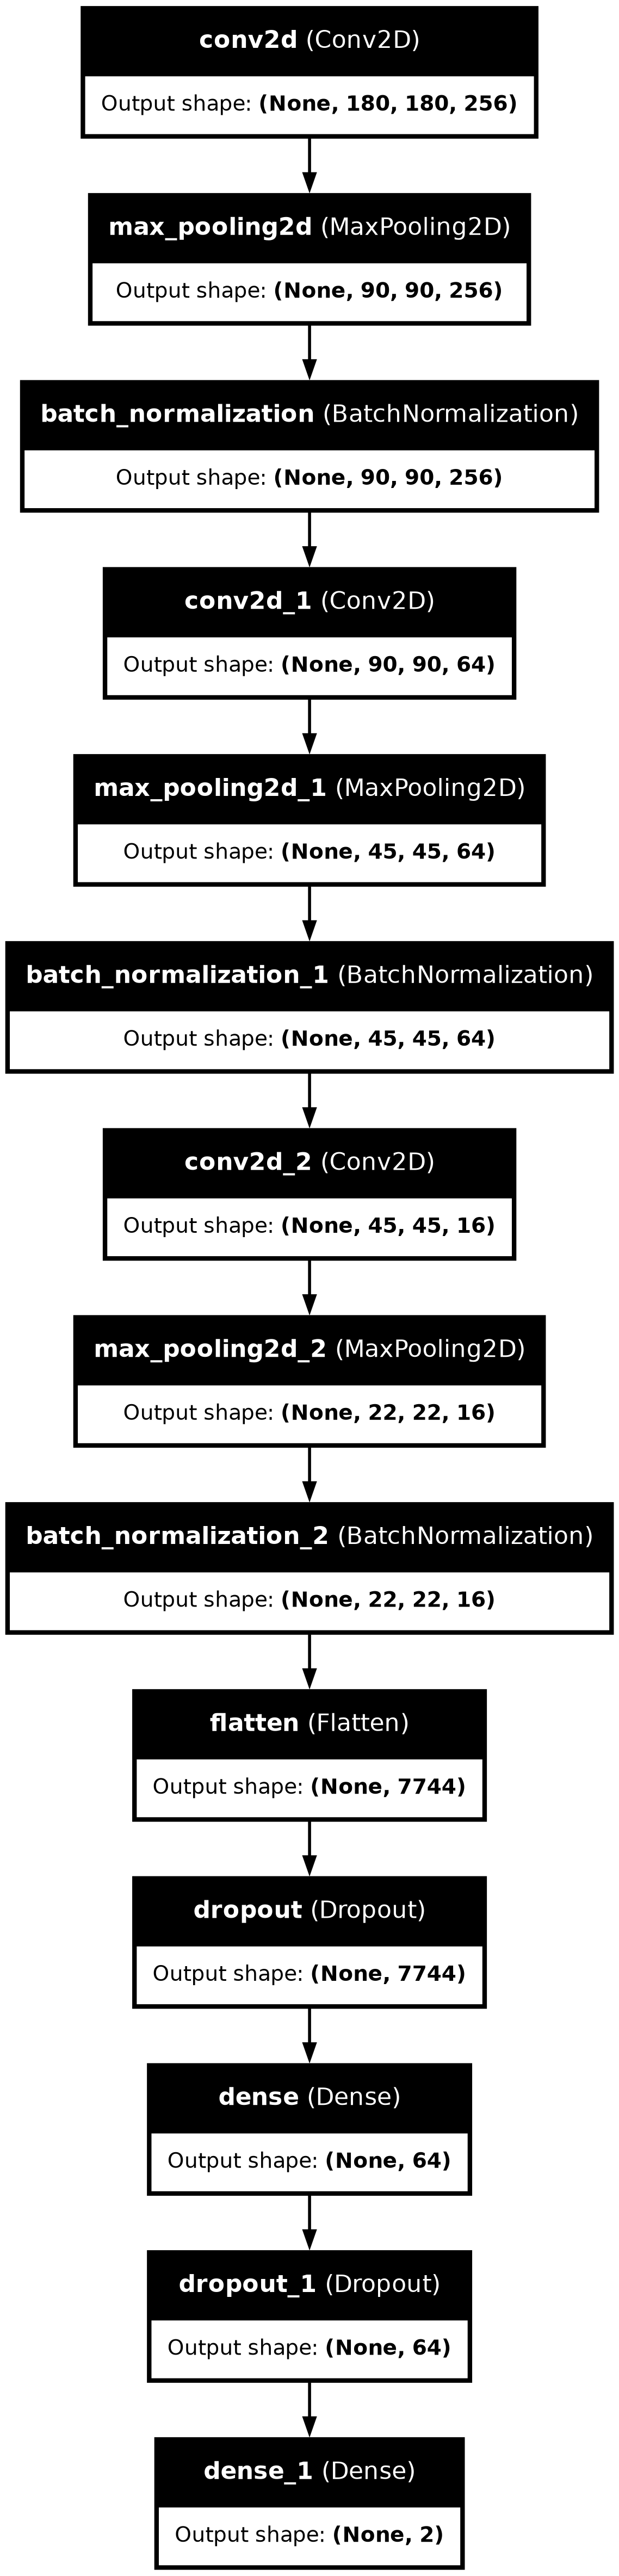

In [10]:
from tensorflow.keras.utils import plot_model

plot_model(model,

           to_file='keras_model_plot.png',

           show_shapes=True,

           show_layer_names=True)

In [11]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Loss')
    plt.show()


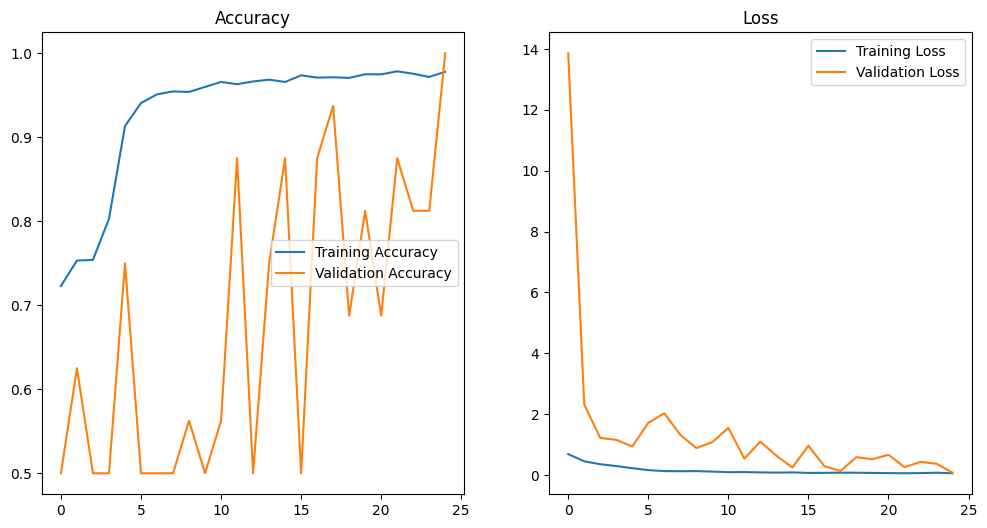

In [12]:
plot_training_history(history)

In [13]:
# Evaluating the model
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc}, Test loss: {test_loss}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 435ms/step - accuracy: 0.7835 - loss: 2.4281
Test accuracy: 0.7868589758872986, Test loss: 2.3817460536956787
